In [30]:
import numpy as np
import pandas as pd
import os
import time
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
sns.set_style('darkgrid')
import shutil
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import torch as t
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision as tv
from tempfile import TemporaryDirectory


In [2]:
from pprint import pprint as pp

In [3]:
## Device Selection
device=t.device('cuda' if t.cuda.is_available()  else  'cpu')
device

device(type='cuda')

In [15]:
## Processed Data Folders
train_folder=os.path.abspath('./augs/Train')
val_folder=os.path.abspath('./augs/Val')
test_folder=os.path.abspath('./augs/Test')

### Custom  Dataset

In [17]:
class AmurTigerDataset(Dataset):
    def __init__(self,root_folder):
        self.root_folder=root_folder
        self.df=pd.DataFrame()
        for label in os.listdir(root_folder):
            label_folder=os.path.join(root_folder,label)
            for img_file in os.listdir(label_folder):
                img_filepath=os.path.join(label_folder,img_file)
                row_df=pd.DataFrame({'labels':[label],'filepaths':[img_filepath]})
                self.df=pd.concat([self.df,row_df])
        self.df.reset_index(drop=True,inplace=True)
        self.x=self.df[['filepaths']]
        self.y=pd.get_dummies(self.df['labels']).astype(np.float32)
        self.columns=list(self.y.columns)
    
    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        img_path=self.x.iloc[index].values[0]
        img=t.load(img_path)
        y_label=t.tensor(self.y.iloc[index].values)
        return img,y_label

### Loading Data

In [18]:
train_dataset=AmurTigerDataset(root_folder=train_folder)
val_dataset=AmurTigerDataset(root_folder=val_folder)
test_dataset=AmurTigerDataset(root_folder=test_folder)

In [19]:
# Create data loaders for our datasets; shuffle for training, not for validation
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

### Viewing Normalized Image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


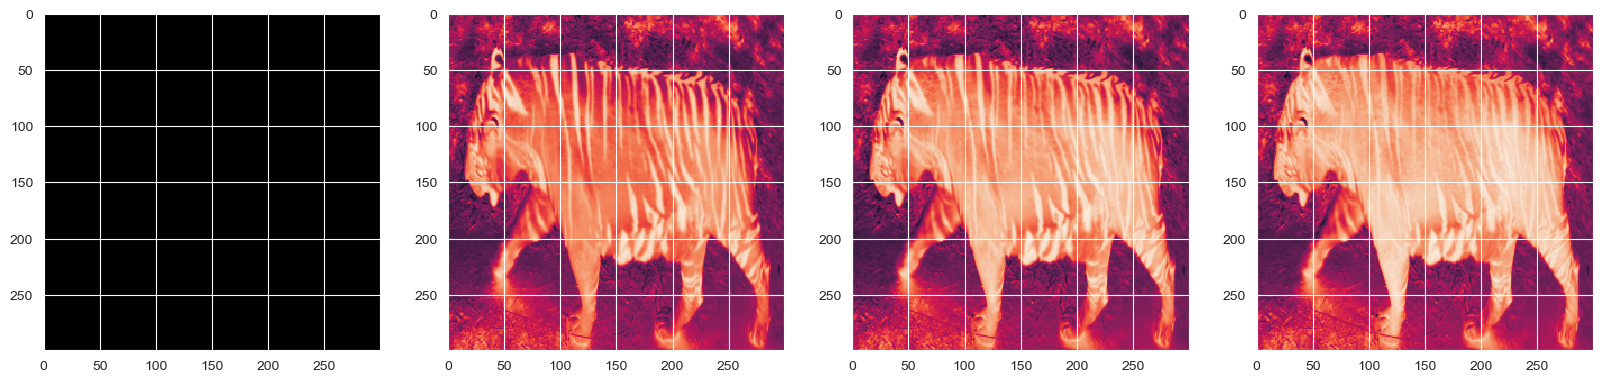

In [23]:
img,label=next(iter(train_dataset))
img=img.numpy()
img=img.reshape(img.shape+(1,))
n_img=np.concatenate([img[0],img[1],img[2]],axis=2)
f,ax=plt.subplots(1,4,figsize=(20,5))
ax[0].imshow(n_img)
ax[1].imshow(n_img[:,:,0])
ax[2].imshow(n_img[:,:,1])
ax[3].imshow(n_img[:,:,2])

### Downloading and Loading ResNet

In [24]:
os.environ['TORCH_HOME'] = 'models\\resnet' #setting the environment variable
resnet = tv.models.resnet18(pretrained=True)

c:\Users\iiavalorii\.conda\envs\mlenv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\iiavalorii\.conda\envs\mlenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Neural Network Model

In [25]:
class AmurTigerModel(nn.Module):
    def __init__(self):
        super(AmurTigerModel, self).__init__()
        self.fc1 = nn.Linear(in_features=1000, out_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=256)
        self.fc3 = nn.Linear(in_features=256, out_features=107)
        self.resnet=resnet.to(device)
    def forward(self, x):
        x = resnet(x)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc2(x))
        return self.fc3(x)

### Training Model

In [31]:
dataloaders={'train':train_loader,'val': val_loader}
dataset_sizes = {'train':train_dataset.__len__(),'val': val_dataset.__len__()}

In [32]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    train_loss=[]
    val_loss=[]
    train_acc=[]
    val_acc=[]
    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        t.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with t.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = t.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    _,truth= t.max(labels, 1)
                    running_corrects += t.sum(preds == truth)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]
                if phase == 'train':
                    train_loss.append(epoch_loss)
                    train_acc.append(epoch_acc)
                else:
                    val_loss.append(epoch_loss)
                    val_acc.append(epoch_acc)
                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    t.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(t.load(best_model_params_path))
    details={'train_loss':train_loss,'train_acc':train_acc,'val_loss':val_loss,'val_acc':val_acc}
    return model,details

In [33]:
model=AmurTigerModel().to(device)

## Citerion
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [34]:
model_ft,details = train_model(model, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=100)

Epoch 0/99
----------
train Loss: 3.3837 Acc: 0.1488
val Loss: 7.0595 Acc: 0.0033

Epoch 1/99
----------
train Loss: 1.6250 Acc: 0.4812
val Loss: 19.1572 Acc: 0.0132

Epoch 2/99
----------
train Loss: 0.9909 Acc: 0.6670
val Loss: 6.1155 Acc: 0.0132

Epoch 3/99
----------
train Loss: 0.6695 Acc: 0.7789
val Loss: 9.0047 Acc: 0.0099

Epoch 4/99
----------
train Loss: 0.4754 Acc: 0.8384
val Loss: 9.0060 Acc: 0.0364

Epoch 5/99
----------
train Loss: 0.3570 Acc: 0.8825
val Loss: 47.3145 Acc: 0.0066

Epoch 6/99
----------
train Loss: 0.2831 Acc: 0.9075
val Loss: 17.3863 Acc: 0.0199

Epoch 7/99
----------
train Loss: 0.1242 Acc: 0.9628
val Loss: 2.5488 Acc: 0.4901

Epoch 8/99
----------
train Loss: 0.0937 Acc: 0.9718
val Loss: 16.1374 Acc: 0.1192

Epoch 9/99
----------
train Loss: 0.0790 Acc: 0.9776
val Loss: 3.8503 Acc: 0.3543

Epoch 10/99
----------
train Loss: 0.0774 Acc: 0.9781
val Loss: 7.3206 Acc: 0.2517

Epoch 11/99
----------
train Loss: 0.0647 Acc: 0.9824
val Loss: 12.9405 Acc: 0.106

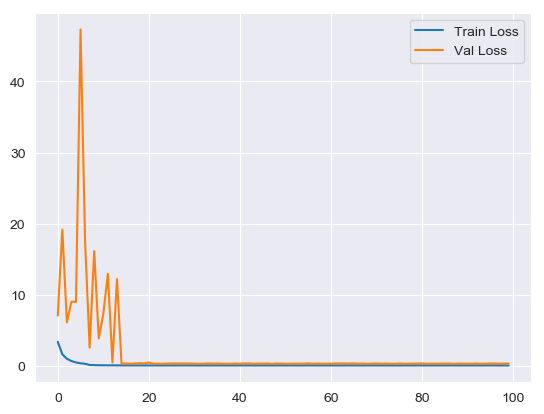

In [35]:
plt.plot(details['train_loss'],label='Train Loss')
plt.plot(details['val_loss'], label='Val Loss')
plt.legend()

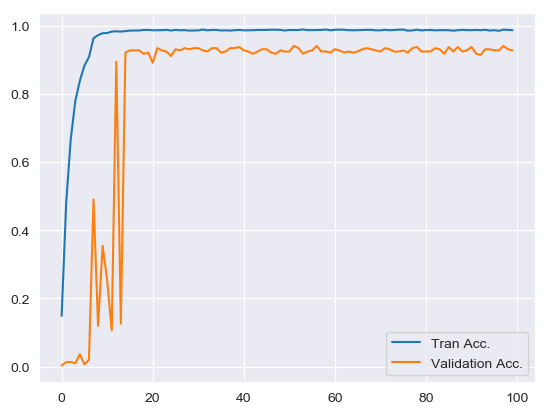

In [37]:
train_acc=[v.item() for v in details['train_acc']]
val_acc=[v.item() for v in details['val_acc']]

plt.plot(train_acc,label='Tran Acc.')
plt.plot(val_acc,label='Validation Acc.')
plt.legend()

In [39]:
model_folder=os.path.abspath('./models/AmurTigerModels')
if not os.path.exists(model_folder):
    os.makedirs(model_folder)

In [40]:
model_filename='AT_reid_model.pt'
model_filepath=os.path.join(model_folder,model_filename)

In [41]:
t.save(model,f=model_filepath)

### Testing Model with Test set

In [42]:
def test_model(dataloader, model, loss_fn):
    
    # Total size of dataset for reference
    size = 0
    num_batches = len(dataloader)
    
    # Setting the model under evaluation mode.
    model.eval()

    test_loss, correct = 0, 0
    
    _correct = 0
    _batch_size = 0
    
    batch_loss = {}
    batch_accuracy = {}
    
    with t.no_grad():
        
        # Gives X , y for each batch
        for batch , (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            model.to(device)
            pred = model(X)
            
            batch_loss[batch] = loss_fn(pred, y).item()
            test_loss += batch_loss[batch]
            _batch_size = len(X)
            
            _correct = (pred.argmax(1) == y.argmax(1)).type(t.float).sum().item()
            correct += _correct
            
            size+=_batch_size
            batch_accuracy[batch] = _correct/_batch_size        
    
    ## Calculating loss based on loss function defined
    test_loss /= num_batches
    
    ## Calculating Accuracy based on how many y match with y_pred
    correct /= size
    
    print(f"Valid Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return batch_loss , batch_accuracy

In [43]:
t_batch_loss , t_batch_accuracy=test_model(dataloader=test_loader,model=model,loss_fn=criterion)

Valid Error: 
 Accuracy: 92.3%, Avg loss: 0.266842 

